![](https://cs12.pikabu.ru/post_img/2021/04/03/11/161747325719360908.jpg)

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import re

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from lightgbm import LGBMClassifier

# Read data and EDA

In [2]:
data_path = '/kaggle/input/entrepreneurial-competency-in-university-students/data.csv'
df = pd.read_csv(data_path)

First 3 objects

In [3]:
df.head(3)

,EducationSector,IndividualProject,Age,Gender,City,Influenced,Perseverance,DesireToTakeInitiative,Competitiveness,SelfReliance,StrongNeedToAchieve,SelfConfidence,GoodPhysicalHealth,MentalDisorder,KeyTraits,ReasonsForLack,y
0,Engineering Sciences,No,19,Male,Yes,No,2,2,3,3,2,2,3,Yes,Passion,NaN,1
1,Engineering Sciences,Yes,22,Male,No,Yes,3,3,3,4,4,3,4,Yes,Vision,Just not interested! (Want to work in the corp...,0
2,Engineering Sciences,No,18,Male,Yes,No,3,4,3,3,3,4,4,No,Passion,Not willing to start a venture in India and wa...,0


In [4]:
print(f'Data set сontains {len(df.columns)} features and {len(df)} objects')
print(f'Target(y): whether the student is likely to become an entrepreneur or not - binary')

Data set сontains 17 features and 219 objects
Target(y): whether the student is likely to become an entrepreneur or not - binary


**Check none**

In [5]:
df.isna().agg(['sum', 'mean']).T

,sum,mean
EducationSector,0.0,0.000000
IndividualProject,0.0,0.000000
Age,0.0,0.000000
Gender,0.0,0.000000
City,0.0,0.000000
Influenced,0.0,0.000000
Perseverance,0.0,0.000000
DesireToTakeInitiative,0.0,0.000000
Competitiveness,0.0,0.000000
SelfReliance,0.0,0.000000


Column ReasonsForLack contains 41% none values

In [6]:
df['ReasonsForLack'].iloc[:5]

0                                                  NaN
1    Just not interested! (Want to work in the corp...
2    Not willing to start a venture in India and wa...
3                    Not able to take a Financial Risk
4                                                  NaN
Name: ReasonsForLack, dtype: object

Ok. Columns contain info about Reason for Lack.Column have string type if not none

Just example

In [7]:
df[df['ReasonsForLack'].notna()]['ReasonsForLack'].iloc[0:1][1]

'Just not interested! (Want to work in the corporate sector, or for the government or pursue research or something else)'

In [8]:
df[df['ReasonsForLack'].notna()]['ReasonsForLack'].value_counts().iloc[:5]

ReasonsForLack
Just not interested! (Want to work in the corporate sector, or for the government or pursue research or something else)    41
Academic Pressure                                                                                                          11
Not willing to start a venture in India and waiting for future relocation                                                  10
Lack of Knowledge                                                                                                           7
Academic Pressure, Unwillingness to take risk, Lack of Knowledge                                                            4
Name: count, dtype: int64

The column may contain multiple reasons separated by commas.
For example:
Just not interested! (Want to work in the corporate sector, or for the government or pursue research or something else), Lack of Knowledge, Not able to take a Financial Risk.

A quick inspection shows that the reasons are selected from a predefined list rather than being free-form text.

In [9]:
df_not_na = df['ReasonsForLack'].dropna().copy()

unique_reasons = (
    df_not_na
    .str.replace(r'\(.*?\)', '', regex=True)
    .str.split(', ')
    .explode()
    .str.strip()
    .unique()
)

In [10]:
print(f'Unique reasons : {unique_reasons}\n')
print(f'Number unique reasons: {len(unique_reasons)}')

Unique reasons : ['Just not interested!'
 'Not willing to start a venture in India and waiting for future relocation'
 'Not able to take a Financial Risk' 'Academic Pressure'
 'Lack of Knowledge' 'Parental Pressure' 'Mental Block'
 'Unwillingness to take risk']

Number unique reasons: 8


Number of unique reasons: 8 — this is a strong justification for using MultiLabelBinarizer at the encoding stage.

However, let us verify whether this feature constitutes a direct justification of the target variable.

In [11]:
df['ReasonsForLack_na'] = df['ReasonsForLack'].notna().astype(int)
df[['ReasonsForLack_na', 'y']].corr()

,ReasonsForLack_na,y
ReasonsForLack_na,1.0,-1.0
y,-1.0,1.0


A correlation of 1 indicates that this feature directly justifies the target variable.

If this column is retained, it will result in **data leakage**.

Let's delete it!

In [12]:
df = df.drop(columns = ['ReasonsForLack', 'ReasonsForLack_na'])

**Describe**

In [13]:
df.describe().round(2)

,Age,Perseverance,DesireToTakeInitiative,Competitiveness,SelfReliance,StrongNeedToAchieve,SelfConfidence,GoodPhysicalHealth,y
count,219.00,219.00,219.00,219.00,219.00,219.00,219.00,219.00,219.00
mean,19.75,3.35,3.62,3.59,3.72,3.91,3.58,3.56,0.42
std,1.29,1.00,1.15,1.11,1.05,1.02,1.12,1.10,0.49
min,17.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00
25%,19.00,3.00,3.00,3.00,3.00,3.00,3.00,3.00,0.00
50%,20.00,3.00,4.00,4.00,4.00,4.00,4.00,4.00,0.00
75%,20.00,4.00,5.00,4.50,5.00,5.00,4.00,4.00,1.00
max,26.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,1.00


*Perseverance, DesireToTakeInitiative, Competitiveness, SelfReliance, StrongNeedToAchieve, SelfConfidence, and GoodPhysicalHealth.* => personality_traits 

Have nearly identical statistical properties.

Let us examine the correlation matrix.

In [14]:
num_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = df.select_dtypes(include=['object', 'category']).columns.tolist()

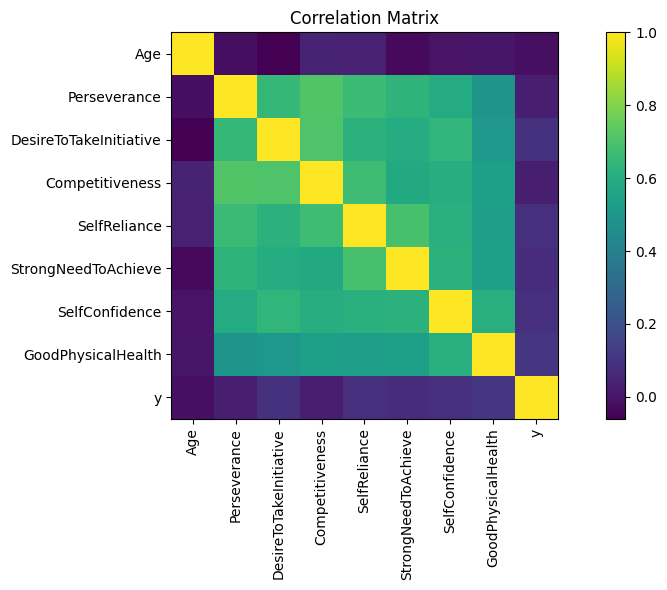

In [15]:
corr_matrix = df[num_features].corr()


plt.figure(figsize=(10, 6))
plt.imshow(corr_matrix)
plt.colorbar()
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

Highly correlated features can be seen.

Join features in personality traits

In [16]:
personality_traits = df[['Perseverance', 'DesireToTakeInitiative', 'Competitiveness',
       'SelfReliance', 'StrongNeedToAchieve', 'SelfConfidence',
       'GoodPhysicalHealth']].copy()

In [17]:
personality_traits_corr = personality_traits.corr().mean()

print(personality_traits_corr.round(2),'\n')
print(f'Mean corr personality trait {personality_traits_corr.mean().round(2)}')

Perseverance              0.68
DesireToTakeInitiative    0.67
Competitiveness           0.69
SelfReliance              0.68
StrongNeedToAchieve       0.67
SelfConfidence            0.67
GoodPhysicalHealth        0.60
dtype: float64 

Mean corr personality trait 0.67


Yes. This columns have **high correlation. Mean = 0.67**

**Number of unique values per categorical feature**

In [18]:
unique_counts = df[cat_features].nunique().reset_index()
unique_counts.columns = ['feature', 'n_unique']
unique_counts

,feature,n_unique
0,EducationSector,9
1,IndividualProject,2
2,Gender,2
3,City,2
4,Influenced,2
5,MentalDisorder,2
6,KeyTraits,5


It's ok

# Feature Engineering

We will combine personality_traits into one feature by averaging the values of this highly correlated features.

In [19]:
df['personality_traits'] = personality_traits.mean(axis=1)
df = df.drop(columns=personality_traits.columns)

We will separate binary features from multi-class features for further encoding.

In [20]:
num_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = df.select_dtypes(include=['object', 'category']).columns.tolist()

In [21]:
binary_features = unique_counts.loc[
    unique_counts.n_unique == 2, 'feature'
].tolist()

multiclass_features = unique_counts.loc[
    unique_counts.n_unique > 2, 'feature'
].tolist()


In [22]:
print(f'Binary features: {binary_features}\n')
print(f'Multiclass features:{multiclass_features}')

Binary features: ['IndividualProject', 'Gender', 'City', 'Influenced', 'MentalDisorder']

Multiclass features:['EducationSector', 'KeyTraits']


## Binary encoding [Binary features]

In [23]:
#binary features
for col in binary_features:
    if df[col].dtype == 'object':
        df[col] = df[col].astype('category').cat.codes

##  One hot encoding [Multi-class features]

In [24]:
#one hot encoding
df = pd.get_dummies(
    df,
    columns=multiclass_features,
    drop_first=False
)

Processed data frame

In [25]:
df.head(3)

,IndividualProject,Age,Gender,City,Influenced,MentalDisorder,y,personality_traits,"EducationSector_Art, Music or Design","EducationSector_Economic Sciences, Business Studies, Commerce and Law",...,EducationSector_Language and Cultural Studies,EducationSector_Mathematics or Natural Sciences,"EducationSector_Medicine, Health Sciences",EducationSector_Others,"EducationSector_Teaching Degree (e.g., B.Ed)",KeyTraits_Passion,KeyTraits_Positivity,KeyTraits_Resilience,KeyTraits_Vision,KeyTraits_Work Ethic
0,0,19,1,1,0,1,1,2.428571,False,False,...,False,False,False,False,False,True,False,False,False,False
1,1,22,1,0,1,1,0,3.428571,False,False,...,False,False,False,False,False,False,False,False,True,False
2,0,18,1,1,0,0,0,3.428571,False,False,...,False,False,False,False,False,True,False,False,False,False


# Split data

In [26]:
y = df['y']
X = df.drop(columns=['y'])

#train / test split (85% / 15%)
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.15,
    random_state=777
)

X_train.shape, X_test.shape

((186, 21), (33, 21))

Feature names were standardized by converting them to lowercase and removing special characters to ensure consistency and compatibility with downstream models (e.g., LightGBM).

In [27]:
def clean_column_names(df):
    df = df.copy()
    df.columns = (
        df.columns
        .str.lower()
        .str.replace(r'[^\w]+', '_', regex=True)
        .str.strip('_')
    )
    return df


X_train = clean_column_names(X_train)
X_test = clean_column_names(X_test)

# Models

In [28]:
results = {}

In [29]:
model_lr = LogisticRegression(max_iter=1000, random_state=777)

model_lr.fit(X_train, y_train)

y_pred = model_lr.predict(X_test)

results['LogisticRegression'] = accuracy_score(y_test, y_pred).round(2)

print("Accuracy:", accuracy_score(y_test, y_pred).round(2))
print(classification_report(y_test, y_pred))

Accuracy: 0.48
              precision    recall  f1-score   support

           0       0.57      0.65      0.60        20
           1       0.30      0.23      0.26        13

    accuracy                           0.48        33
   macro avg       0.43      0.44      0.43        33
weighted avg       0.46      0.48      0.47        33



In [30]:
dt_model = DecisionTreeClassifier(
    random_state=777,
    max_depth=6
)

dt_model.fit(X_train, y_train)


y_pred = dt_model.predict(X_test)

results['DecisionTreeClassifier'] = accuracy_score(y_test, y_pred).round(2)

print("Accuracy:", accuracy_score(y_test, y_pred).round(2))
print(classification_report(y_test, y_pred))

Accuracy: 0.58
              precision    recall  f1-score   support

           0       0.69      0.55      0.61        20
           1       0.47      0.62      0.53        13

    accuracy                           0.58        33
   macro avg       0.58      0.58      0.57        33
weighted avg       0.60      0.58      0.58        33



In [31]:
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=777,
    n_jobs=-1
)


rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)


results['RandomForestClassifier'] = accuracy_score(y_test, y_pred).round(2)

print("Accuracy:", accuracy_score(y_test, y_pred).round(2))
print(classification_report(y_test, y_pred))

Accuracy: 0.61
              precision    recall  f1-score   support

           0       0.68      0.65      0.67        20
           1       0.50      0.54      0.52        13

    accuracy                           0.61        33
   macro avg       0.59      0.59      0.59        33
weighted avg       0.61      0.61      0.61        33



In [32]:
lgb_model = LGBMClassifier(n_estimators=300,
                           learning_rate=0.05,
                           max_depth=3,
                           verbosity=-1,
                           random_state=777)

lgb_model.fit(X_train, y_train)

y_pred = lgb_model.predict(X_test)

results['LGBMClassifier'] = accuracy_score(y_test, y_pred).round(2)

print("Accuracy:", accuracy_score(y_test, y_pred).round(2))
print(classification_report(y_test, y_pred))

Accuracy: 0.7
              precision    recall  f1-score   support

           0       0.73      0.80      0.76        20
           1       0.64      0.54      0.58        13

    accuracy                           0.70        33
   macro avg       0.68      0.67      0.67        33
weighted avg       0.69      0.70      0.69        33



In [33]:
results_df = (
    pd.DataFrame.from_dict(results, orient='index', columns=['accuracy'])
    .reset_index()
    .rename(columns={'index': 'model'})
    .sort_values(by='accuracy', ascending=1)
)

results_df

,model,accuracy
0,LogisticRegression,0.48
1,DecisionTreeClassifier,0.58
2,RandomForestClassifier,0.61
3,LGBMClassifier,0.70
